## Using LSTMs with the subwords dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Get the dataset

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2022-10-19 13:07:13--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 2404:6800:4009:81b::200e, 142.250.76.206
Connecting to drive.google.com (drive.google.com)|2404:6800:4009:81b::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fre4u6aj9s8dmb3foosaka9s4ln50dhm/1666164975000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=ec8c773a-93d9-45b3-bf51-8ee3345fa96e [following]
--2022-10-19 13:07:13--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fre4u6aj9s8dmb3foosaka9s4ln50dhm/1666164975000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=ec8c773a-93d9-45b3-bf51-8ee3345fa96e
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 2404:6800:4009:82e::2001, 142.250.199.161
Connecting to doc-

In [3]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

# Extract out sentences and labels
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
# Print some example sentences and labels

for x in range(2):
    print(sentences[x])
    print(labels[x])
    print('\n')

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




## Create a subwords dataset

In [6]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size,max_subword_length=5)
print('Vocab Size is:-',tokenizer.vocab_size)

Vocab Size is:- 999


In [7]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [8]:
# Separately print out each subword, decoded
for i in encoded:
    print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


## Replace sentence data with encoded subwords

In [9]:
for i, sentence in enumerate(sentences):
    sentences[i] = tokenizer.encode(sentence)

In [10]:
# Check the sentences are appropriately replaced
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


## Final pre-processing

In [11]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Create the model using an Embedding

In [12]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [13]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))


Epoch 1/30
50/50 [==============================] - 1s 4ms/step - loss: 0.6921 - accuracy: 0.5116 - val_loss: 0.6963 - val_accuracy: 0.4236
Epoch 2/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6870 - accuracy: 0.5675 - val_loss: 0.6960 - val_accuracy: 0.4461
Epoch 3/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.5945 - val_loss: 0.6854 - val_accuracy: 0.5188
Epoch 4/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6618 - accuracy: 0.6717 - val_loss: 0.6770 - val_accuracy: 0.5363
Epoch 5/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6396 - accuracy: 0.7238 - val_loss: 0.6631 - val_accuracy: 0.5614
Epoch 6/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6110 - accuracy: 0.7596 - val_loss: 0.6438 - val_accuracy: 0.6291
Epoch 7/30
50/50 [==============================] - 0s 2ms/step - loss: 0.5749 - accuracy: 0.7897 - val_loss: 0.6096 - val_accuracy: 0.6992
Epoch 8/30
50/50 [==

## Plot the accuracy and loss

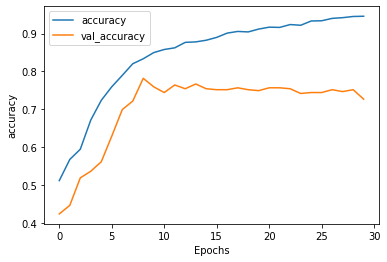

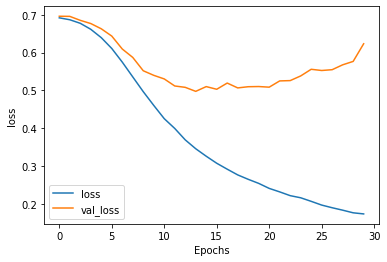

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Define a function to predict the sentiment of reviews

In [16]:
def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True):
    
    new_sequences = []
    
    for i, frvw in enumerate(new_sentences):
        new_sequences.append(tokenizer.encode(frvw))
        
    trunc_type = 'post'
    padding_type = 'post'

    new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)

    classes = model.predict(new_reviews_padded)
    
    for x in range(len(new_sentences)):
        if (show_padded_sequence):
            print(new_reviews_padded[x])
            
        print(new_sentences[x])
        print(classes[x])
        print('\n')

In [17]:
# Use the model to predict some reviews   
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)


[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.93192315]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.14796725]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.3902477]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.13354483]


[  1 109 228 540 237 635 24

## Define a function to train and show the results of models with different layers

In [26]:
def fit_model_now(model, sentences):
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))
    return history

def plot_results(history):
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    
def fit_model_and_show_result(model, sentences):
    history = fit_model_now(model, sentences)
    plot_results(history)
    predict_review(model,sentences)

## Add a bidirectional LSTM

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 5s 38ms/step - loss: 0.6902 - accuracy: 0.5487 - val_loss: 0.6890 - val_accuracy: 0.5113
Epoch 2/30
50/50 [==============================] - 1s 21ms/step - loss: 0.6441 - accuracy: 0.6497 - val_lo

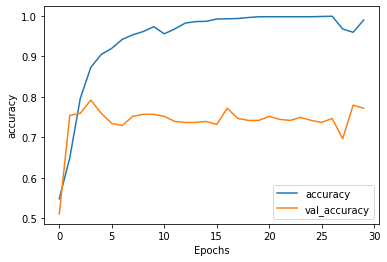

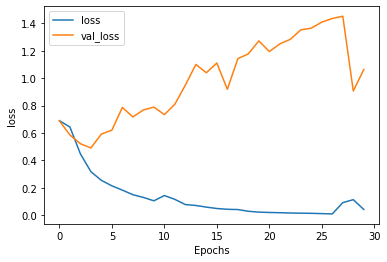

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9980527]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.02435103]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.30581754]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.09554511]


[  1 109 228 540 237 635 24

In [25]:
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_result(model_bidi_lstm, fake_reviews)

## Use multiple bidirectional layers

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 7         
Total params: 26,701
Trainable params: 26,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 8s 58ms/step - loss: 0.6907 - accuracy: 0.5223 - val_loss: 0.695

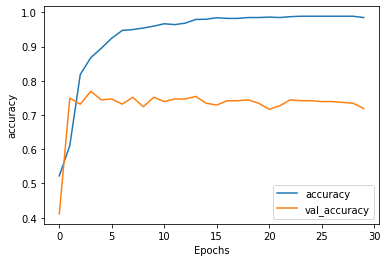

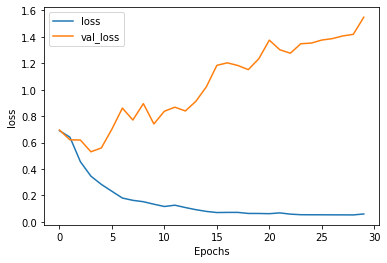

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9999122]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.02348533]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.9993645]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.02561072]


[  1 109 228 540 237 635 241

In [32]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_result(model_multiple_bidi_lstm, fake_reviews)

## Compare predictions for all the models

In [33]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [34]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
lovely
[0.94860995]


dreadful
[0.39442426]


stay away
[0.7364242]


everything was hot exactly as I wanted
[0.8135667]


everything was not exactly as I wanted
[0.61190665]


they gave us free chocolate cake
[0.79072785]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.02277398]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.65308565]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.8354614]


that place does not have quality meals and it isn't a good place to go for dinner
[0.90909106]




In [35]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
lovely
[0.9958497]


dreadful
[0.00983953]


stay away
[0.0321736]


everything was hot exactly as I wanted
[0.94402105]


everything was not exactly as I wanted
[0.08452785]


they gave us free chocolate cake
[0.8938354]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.01047695]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.77855897]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9995584]


that place does not have quality meals and it isn't a good place to go for dinner
[0.5250124]




In [36]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:
lovely
[0.9999099]


dreadful
[0.04256409]


stay away
[0.03402835]


everything was hot exactly as I wanted
[0.99954134]


everything was not exactly as I wanted
[0.07044145]


they gave us free chocolate cake
[0.9998851]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.02745017]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.0257054]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9951377]


that place does not have quality meals and it isn't a good place to go for dinner
[0.0341965]


